# Machine Learning Project Serie 1: 
# IMDB movie review sentiment classification

# Episode 2: Improving Features Encoding

This machine learning project will explore the IMDB movie review sentiment classification dataset and try out a few different machine learning approaches to find out which perform the best on such problem. This episode will focus on improving the way features being encoded. Many details will be simplified compared to Episode 1 to focus on features encoding.

# I. Importing libraries

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
import keras as K
import time
import csv

Instructions for updating:
non-resource variables are not supported in the long term


# II. Extracting data

In [2]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

<__array_function__ internals>:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:159: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/opt/conda/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:160: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do t

# III. Investigating datasets

### 1. Word dictionary structure

In [3]:
word_dict = tf.keras.datasets.imdb.get_word_index(path="imdb_word_index.json")

In [4]:
word_dict = dict(sorted(word_dict.items(), key=lambda item: item[1]))

In [5]:
word_list = list(word_dict)
word_list.insert(0, str(0)) # To make the index of each word matches it position in original dictionary

### 2. Ordering word uses in positive/negative comments
- 'negative_word_dict' records the number of appearances of each word in negative comments
- 'positive_word_dict' records the number of appearances of each word in positive comments

In [6]:
def signed_word_dict(sign):
    required_word_len = 2
    signed_dict = {}
    # Loop through all training examples to find examples with labels match input signs
    for i in range(len(x_train)):
        if y_train[i] == sign:
            # Loop through all words in comment and record into signed_dict
            for w in set(x_train[i]):
                if w < len(word_list) and len(word_list[w]) > required_word_len: # Clean broken data and unhelpful data
                    if word_list[w] in signed_dict:
                        signed_dict[word_list[w]] += 1
                    else:
                        signed_dict[word_list[w]] = 1
    
    return signed_dict

In [7]:
# Assign word appearances to their corresponding dictionaries
negative_word_dict = signed_word_dict(0)
positive_word_dict = signed_word_dict(1)

In [8]:
# Testing a few examples
word = 'beautiful'
print("#Appearances in negative comments:", negative_word_dict[word])
print("#Appearances in positive comments:", positive_word_dict[word])

#Appearances in negative comments: 839
#Appearances in positive comments: 1098


- 'negative_inclined_dict' records the how many times does each word appear $more$ in negative comments than in positive ones
- 'positive_inclined_dict' records the how many times does each word appear $more$ in positive comments than in negative ones

In [9]:
def sign_inclined_dict(inclined, uninclined):
    inclined_dict_output = {} # Output
    
    # Assign inclined dictionaries
    dicts = [negative_word_dict, positive_word_dict]
    inclined_dict = dicts[inclined]
    uninclined_dict = dicts[uninclined]
    
    # Loop through all words in the list and record apearance differences
    for word in inclined_dict:
        if word in uninclined_dict:
            inclined_dict_output[word] = inclined_dict[word] - uninclined_dict[word]
        else:
            inclined_dict_output[word] = inclined_dict[word]
    
    return inclined_dict_output

In [10]:
negative_inclined_dict = sign_inclined_dict(0, 1)
negative_inclined_dict = dict(sorted(negative_inclined_dict.items(), reverse=True, key=lambda item: item[1]))

negative_inclined_list = list(negative_inclined_dict)

In [11]:
positive_inclined_dict = sign_inclined_dict(1, 0)
positive_inclined_dict = dict(sorted(positive_inclined_dict.items(), reverse=True, key=lambda item: item[1]))

positive_inclined_list = list(positive_inclined_dict)

In [12]:
# Testing with a few examples
print(positive_inclined_list[:100])

['him', 'where', 'did', 'other', 'much', 'time', 'shot', 'small', 'acting', 'version', 'their', 'definitely', 'give', 'point', 'actors', 'into', 'probably', 'movie', 'young', 'these', 'got', 'heart', 'several', 'there', 'starts', 'plot', 'boring', 'whole', 'fight', 'themselves', 'course', "wasn't", 'together', 'almost', 'its', 'money', 'say', 'right', 'make', 'humor', 'played', 'having', 'worth', 'town', 'like', 'need', 'working', 'otherwise', 'all', 'many', 'actually', 'itself', 'lines', 'effects', 'find', 'hilarious', 'may', 'use', 'made', 'police', 'down', 'anyone', 'supporting', 'action', 'believe', 'world', 'audience', 'about', 'problems', 'far', 'wonderful', 'seem', 'gets', 'care', 'art', 'help', 'romantic', 'sound', 'box', 'can', 'original', 'hell', 'telling', 'taste', 'hard', 'suspense', 'playing', 'talk', 'how', 'opinion', 'plenty', 'date', 'others', 'lives', 'name', 'television', 'seen', 'want', 'making', 'needs']


# IV. Data preprocessing
### 1. Choosing features:
From the dictionaries above, I will choose top 150 words that appear more in negative comments and top 150 words that appear more in positive comments as their appearances are likely to drive the sentiment of a comment.

In [13]:
# Check if the 2 lists overlap:
print("2 chosen lists overlap?", not set(negative_inclined_list[:500]).isdisjoint(set(positive_inclined_list[:500])))

2 chosen lists overlap? False


In [14]:
max_features = 300  # Choose maximum n most used words
required_len = 2     # But exclude the words that does not match required length

def choose_word_index():
    chosen_indexes = []
    for i in range(int(max_features/2)):
        chosen_indexes.append(word_dict[negative_inclined_list[i]])
    for i in range(int(max_features/2)):
        chosen_indexes.append(word_dict[positive_inclined_list[i]])
    return chosen_indexes

In [15]:
accounted_word_indexes = choose_word_index()
nof_features = len(accounted_word_indexes)
print("Number of words picked: " + str(nof_features))

Number of words picked: 300


### 2. Splitting original sets to train/validation/test sets:
Original test set will be kept the way it is. Only original training set is split into train/validation sets

In [16]:
initial_train_len = x_train.shape[0]
print("Training set size : " + str(initial_train_len))

initial_test_len = x_test.shape[0]
print("Testing set shape : " + str(initial_test_len) + '\n')

# Split original data sets to train/validation/test sets:
validation_len = 5000

train_set      = (x_train[0 : initial_train_len - validation_len], y_train[0 : initial_train_len - validation_len])
new_train_len  = len(train_set[0])
print("\nNew training set size  :", new_train_len)

validation_set = (x_train[initial_train_len - validation_len : ],  y_train[initial_train_len - validation_len : ])
new_validation_len = len(validation_set[0])
print("New validation set size:", new_validation_len)

test_set       = (x_test, y_test)
new_test_len = len(test_set[0])
print("New testing set size   :", new_test_len)

Training set size : 25000
Testing set shape : 25000


New training set size  : 20000
New validation set size: 5000
New testing set size   : 25000


### 3. Recostructing input data:
Turning original input data of shape (nof_examples, *undefined*) to (nof_features, nof_examples) 

In [17]:
def construct_input(initial_input):
    new_input = []
    for word_index in accounted_word_indexes:
        if word_index in initial_input:
            new_input.append(1)
        else:
            new_input.append(0)
    return new_input

In [18]:
# Initialize new train/validation/test sets
new_x_train      = np.zeros((new_train_len,      nof_features))
new_y_train      = np.zeros((new_train_len,      1))

new_x_validation = np.zeros((new_validation_len, nof_features))
new_y_validation = np.zeros((new_validation_len, 1))

new_x_test       = np.zeros((new_test_len,       nof_features))
new_y_test       = np.zeros((new_test_len,       1))

# Reconstruct the train/validation/test sets to the aforementioned format:

# TRAINING SET:
for example_index in range(new_train_len):
    new_x_train[example_index]      = construct_input(train_set[0][example_index])
    new_y_train[example_index]      =                 train_set[1][example_index]

# VALIDATION SET
for example_index in range(new_validation_len):
    new_x_validation[example_index] = construct_input(validation_set[0][example_index])
    new_y_validation[example_index] =                 validation_set[1][example_index]

# TEST SET
for example_index in range(new_test_len):
    new_x_test[example_index]       = construct_input(test_set[0][example_index])
    new_y_test[example_index]       =                 test_set[1][example_index]
    
# Transposing the sets for simpler usage later on
new_x_train      = new_x_train.T
new_y_train      = new_y_train.T

new_x_validation = new_x_validation.T
new_y_validation = new_y_validation.T

new_x_test       = new_x_test.T
new_y_test       = new_y_test.T

# V. Machine Learning Models
3 different neural network models will be trained on training set and validated on validation set to decide which model will be used to test with the test set. The models are:
- Neural network with 0 hidden layer, without regularization
- Neural network with 2 hidden layer, without regularization
- Neural network with 3 hidden layer, without regularization

### 1. Model One: 
Neural network with 0 hidden layer, without regularization
 - Final layer will have Sigmoid activation

In [19]:
# Initialize parameters for model One:
def initialize_params_m1():
    # Weights and Biases:
    W1 = tf.get_variable('W1_m1', [1 ,nof_features], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=20))
    b1 = tf.get_variable('b1_m1', [1,1], initializer = tf.zeros_initializer())
    parameters = {'W1': W1, 'b1': b1}
    return parameters

In [20]:
# Forward propagation for model One:
def forward_m1(X, parameters):
    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.sigmoid(Z1)
    return A1

### 2. Model Two: 
Neural network with 2 hidden layers, without regularization
 - Hidden layer 1 has (nof_features/3*2) units (Leaky ReLu activation)
 - Hidden layer 2 has (nof_features/3*1) units (Leaky ReLu activation)
 - Final layer will have Sigmoid activation

In [51]:
# Initialize parameters for model Two:
def initialize_params_m2():
    hl1_units = int(nof_features/3*2)
    hl2_units = int(nof_features/3*1)
    # Weights and Biases:
    W1 = tf.get_variable('W1_m2', [hl1_units, nof_features], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=20))
    b1 = tf.get_variable('b1_m2', [hl1_units, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable('W2_m2', [hl2_units, hl1_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=30))
    b2 = tf.get_variable('b2_m2', [hl2_units, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable('W3_m2', [1, hl2_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=40))
    b3 = tf.get_variable('b3_m2', [1, 1], initializer = tf.zeros_initializer())
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3}
    return parameters

In [52]:
# Forward propagation for model Two:
def forward_m2(X, parameters):
    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.leaky_relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.leaky_relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.sigmoid(Z3)
    
    return A3

### 3. Model Three:
Neural network with 2 hidden layer, with regularization
- Hidden layer 1 has (nof_features/3*2) units (Leaky ReLu activation)
- Hidden layer 2 has (nof_features/3*1) units (Leaky ReLu activation)
- Hidden layer 3 has (nof_features/5) units (Leaky ReLu activation)
- Final layer will have Sigmoid activation

In [23]:
# Initialize parameters for model Three:
def initialize_params_m3():
    hl1_units = int(nof_features/3*2)
    hl2_units = int(nof_features/3*1)
    hl3_units = int(nof_features/5)
    # Weights and Biases:
    W1 = tf.get_variable('W1_m3', [hl1_units, nof_features], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=20))
    b1 = tf.get_variable('b1_m3', [hl1_units, 1], initializer = tf.zeros_initializer())
    
    W2 = tf.get_variable('W2_m3', [hl2_units, hl1_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=30))
    b2 = tf.get_variable('b2_m3', [hl2_units, 1], initializer = tf.zeros_initializer())
    
    W3 = tf.get_variable('W3_m3', [hl3_units, hl2_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=40))
    b3 = tf.get_variable('b3_m3', [hl3_units, 1], initializer = tf.zeros_initializer())
    
    W4 = tf.get_variable('W4_m3', [1, hl3_units], initializer = tf.random_normal_initializer(mean=0.0, stddev=0.05, seed=50))
    b4 = tf.get_variable('b4_m3', [1, 1], initializer = tf.zeros_initializer())
    parameters = {'W1': W1, 'b1': b1, 'W2': W2, 'b2': b2, 'W3': W3, 'b3': b3, 'W4': W4, 'b4': b4}
    return parameters

In [24]:
# Forward propagation for model Three:
def forward_m3(X, parameters):
    # Extract parameters
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    
    # Forward propagation
    Z1 = tf.add(tf.matmul(W1, X), b1)
    A1 = tf.nn.leaky_relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)
    A2 = tf.nn.leaky_relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.leaky_relu(Z3)
    
    Z4 = tf.add(tf.matmul(W4, A3), b4)
    A4 = tf.sigmoid(Z4)
    
    return A4

### Modeling and Training

In [53]:
# Make prediction based on final activation units for model One:
def predict(A):
    prediction = tf.cast(tf.greater_equal(A, 0.5), 'float') # Choose threshold at 0.5
    return prediction

In [54]:
def model_nn(X_train_input, Y_train_input, model_name='m1', learning_rate=0.05, epochs=2000, print_loss_interval=10):
    
    tf.reset_default_graph()
    
    # Creating neural network model input:
    X = tf.placeholder(tf.float32, [nof_features, None], name='X') # The inputs
    Y = tf.placeholder(tf.float32, [1, None], name='Y')            # The labels
    
    # Initializing parameters of the neural network and output final activation units
    parameters = {}
    if model_name == 'm1':
        parameters = initialize_params_m1()
        A = forward_m1(X, parameters)
    elif model_name == 'm2':
        parameters = initialize_params_m2()
        A = forward_m2(X, parameters)
    elif model_name == 'm3':
        parameters = initialize_params_m3()
        A = forward_m3(X, parameters)
    
    # Predict sentimental classification unit based on 'A'
    prediction = predict(A)
    
    # Loss function and optimizing method
    Loss = tf.reduce_mean(tf.square(tf.subtract(A, Y)))
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(Loss)

    # List to store the lost values after some interations for later visualization
    loss_values = [] 
    iterations  = range(1, epochs+1)

    # Start training
    init = tf.global_variables_initializer()
    start_time = time.time()
    
    with tf.Session() as sess:
        sess.run(init)
        
        # Run gradient descent for 'epochs' times
        for epoch in range(1, epochs+1):    
            _, loss = sess.run(fetches=[optimizer, Loss], feed_dict={X:X_train_input, Y:Y_train_input})
            loss_values.append(loss)
            
            # Print this as a reference
            if epoch == 1 or epoch % (epochs/print_loss_interval) == 0:
                print("Training loss after", epoch, "iterations:", loss)
              
        # Plot learning curve
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.plot(iterations, loss_values)
        plt.title("Learning curve")
        plt.xlabel("Iterations")
        plt.ylabel("Loss")
        plt.show()

        # Save parameters for accuracy test on training and validation sets
        parameters = sess.run(parameters)
        
        # Training time
        print("The model took approximately", round((time.time() - start_time)/60), "minutes to train\n")
        
        # Accuracy:
        correct_prediction = tf.equal(prediction, Y)
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy     :", accuracy.eval({X: X_train_input,    Y: Y_train_input}))
        print("Validation Accuracy:", accuracy.eval({X: new_x_validation, Y: new_y_validation}))
        print("Validation Loss    :", Loss.eval({X: new_x_validation, Y: new_y_validation}))
        
        return parameters

# VI. Training and Validating ML Models 

### 1. Model One: 

Read saved parameters out of csv files so the model does not have to be retrained everytime.

In [43]:
params_m1 = {}
# Read values if this is NOT the first time the machine is run
params_m1['W1'] = np.loadtxt(open('m1/l1/m1_w1.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, nof_features)
params_m1['b1'] = np.loadtxt(open('m1/l1/m1_b1.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, 1)

Training loss after 1 iterations: 0.26152626
Training loss after 200 iterations: 0.19716802
Training loss after 400 iterations: 0.17217407
Training loss after 600 iterations: 0.15885018
Training loss after 800 iterations: 0.150379
Training loss after 1000 iterations: 0.14440997
Training loss after 1200 iterations: 0.13991752
Training loss after 1400 iterations: 0.1363788
Training loss after 1600 iterations: 0.13349731
Training loss after 1800 iterations: 0.13109137
Training loss after 2000 iterations: 0.12904282


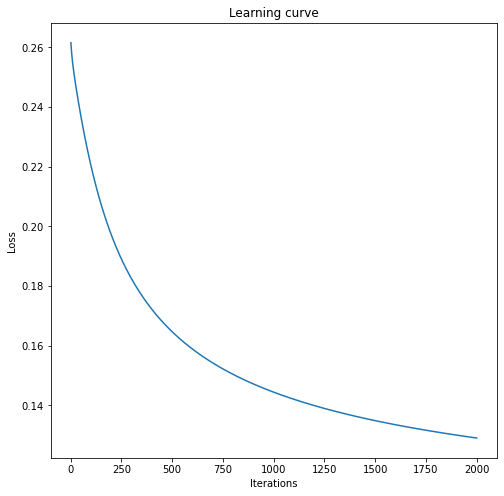

The model took approximately 2 minutes to train

Train Accuracy     : 0.83675
Validation Accuracy: 0.84
Validation Loss    : 0.13038604


In [28]:
params_m1 = model_nn(new_x_train, new_y_train, model_name='m1', learning_rate=0.05, epochs=2000, print_loss_interval=10)

In [29]:
# Store parameters in csv files for later use:
np.savetxt('m1/l1/m1_w1.csv', params_m1['W1'], delimiter=',')
np.savetxt('m1/l1/m1_b1.csv', params_m1['b1'], delimiter=',')

### 2. Model Two:

Read saved parameters out of csv files so the model does not have to be retrained everytime.

In [57]:
params_m2 = {}
m2_hl1_units = int(nof_features/3*2)
m2_hl2_units = int(nof_features/3*1)
# Read values if this is NOT the first time the machine is run
params_m2['W1'] = np.loadtxt(open('m2/l1/m2_w1.csv', 'r'), delimiter=',').astype(np.float32).reshape(m2_hl1_units, nof_features)
params_m2['b1'] = np.loadtxt(open('m2/l1/m2_b1.csv', 'r'), delimiter=',').astype(np.float32).reshape(m2_hl1_units, 1)

params_m2['W2'] = np.loadtxt(open('m2/l2/m2_w2.csv', 'r'), delimiter=',').astype(np.float32).reshape(m2_hl2_units, m2_hl1_units)
params_m2['b2'] = np.loadtxt(open('m2/l2/m2_b2.csv', 'r'), delimiter=',').astype(np.float32).reshape(m2_hl2_units, 1)

params_m2['W3'] = np.loadtxt(open('m2/l3/m2_w3.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, m2_hl2_units)
params_m2['b3'] = np.loadtxt(open('m2/l3/m2_b3.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, 1)

Training loss after 1 iterations: 0.24979624
Training loss after 200 iterations: 0.2408395
Training loss after 400 iterations: 0.2134975
Training loss after 600 iterations: 0.16494094
Training loss after 800 iterations: 0.13690884
Training loss after 1000 iterations: 0.12316782
Training loss after 1200 iterations: 0.115409106
Training loss after 1400 iterations: 0.11055549
Training loss after 1600 iterations: 0.10734817
Training loss after 1800 iterations: 0.10514202
Training loss after 2000 iterations: 0.103550345


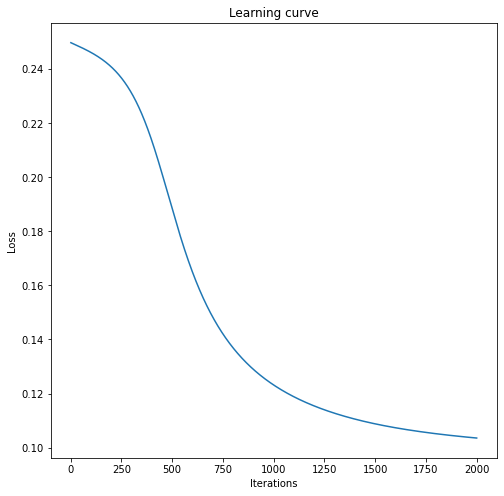

The model took approximately 9 minutes to train

Train Accuracy     : 0.85865
Validation Accuracy: 0.8514
Validation Loss    : 0.10828789


In [55]:
params_m2 = model_nn(new_x_train, new_y_train, model_name='m2', learning_rate=0.05, epochs=2000, print_loss_interval=10)

In [56]:
# Store parameters in csv files for later use:
np.savetxt('m2/l1/m2_w1.csv', params_m2['W1'], delimiter=',')
np.savetxt('m2/l1/m2_b1.csv', params_m2['b1'], delimiter=',')

np.savetxt('m2/l2/m2_w2.csv', params_m2['W2'], delimiter=',')
np.savetxt('m2/l2/m2_b2.csv', params_m2['b2'], delimiter=',')

np.savetxt('m2/l3/m2_w3.csv', params_m2['W3'], delimiter=',')
np.savetxt('m2/l3/m2_b3.csv', params_m2['b3'], delimiter=',')

### 3. Model Three:

Read saved parameters out of csv files so the model does not have to be retrained everytime.

In [47]:
params_m3 = {}
m3_hl1_units = int(nof_features/3*2)
m3_hl2_units = int(nof_features/3*1)
m3_hl3_units = int(nof_features/5)
# Read values if this is NOT the first time the machine is run
params_m3['W1'] = np.loadtxt(open('m3/l1/m3_w1.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl1_units, nof_features)
params_m3['b1'] = np.loadtxt(open('m3/l1/m3_b1.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl1_units, 1)

params_m3['W2'] = np.loadtxt(open('m3/l2/m3_w2.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl2_units, m3_hl1_units)
params_m3['b2'] = np.loadtxt(open('m3/l2/m3_b2.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl2_units, 1)

params_m3['W3'] = np.loadtxt(open('m3/l3/m3_w3.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl3_units, m3_hl2_units)
params_m3['b3'] = np.loadtxt(open('m3/l3/m3_b3.csv', 'r'), delimiter=',').astype(np.float32).reshape(m3_hl3_units, 1)

params_m3['W4'] = np.loadtxt(open('m3/l4/m3_w4.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, m3_hl3_units)
params_m3['b4'] = np.loadtxt(open('m3/l4/m3_b4.csv', 'r'), delimiter=',').astype(np.float32).reshape(1, 1)

Training loss after 1 iterations: 0.25006554
Training loss after 200 iterations: 0.24956381
Training loss after 400 iterations: 0.24886286
Training loss after 600 iterations: 0.24738106
Training loss after 800 iterations: 0.2431503
Training loss after 1000 iterations: 0.22636294
Training loss after 1200 iterations: 0.17028254
Training loss after 1400 iterations: 0.13226025
Training loss after 1600 iterations: 0.11753076
Training loss after 1800 iterations: 0.110215575
Training loss after 2000 iterations: 0.10604973


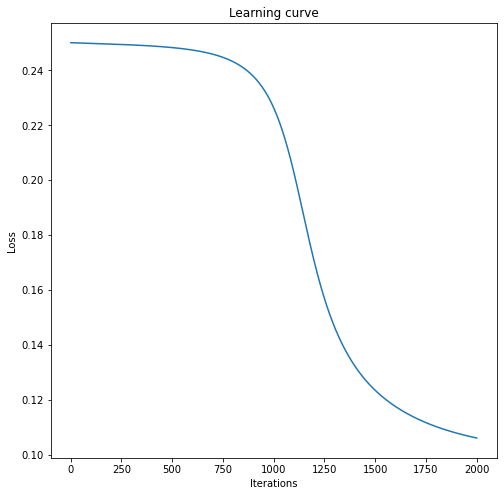

The model took approximately 10 minutes to train

Train Accuracy     : 0.8557
Validation Accuracy: 0.85
Validation Loss    : 0.110275686


In [31]:
params_m3 = model_nn(new_x_train, new_y_train, model_name='m3', learning_rate=0.05, epochs=2000, print_loss_interval=10)

In [46]:
# Store parameters in csv files for later use:
np.savetxt('m3/l1/m3_w1.csv', params_m3['W1'], delimiter=',')
np.savetxt('m3/l1/m3_b1.csv', params_m3['b1'], delimiter=',')

np.savetxt('m3/l2/m3_w2.csv', params_m3['W2'], delimiter=',')
np.savetxt('m3/l2/m3_b2.csv', params_m3['b2'], delimiter=',')

np.savetxt('m3/l3/m3_w3.csv', params_m3['W3'], delimiter=',')
np.savetxt('m3/l3/m3_b3.csv', params_m3['b3'], delimiter=',')

np.savetxt('m3/l4/m3_w4.csv', params_m3['W4'], delimiter=',')
np.savetxt('m3/l4/m3_b4.csv', params_m3['b4'], delimiter=',')

### Conclusion:

Compare result in table:

| |Model One (eps.1)|Model Two (eps.1)|Model Three (eps.1)|
|-|-|-|-|
|# Hidden layers    |0      |2      |3      |
|Training accuracy  |79.255%|80.890%|79.920%|
|Validation accuracy|79.200%|79.740%|79.140%|
|Training loss      |0.15271|0.13650|0.14144|
|Validation loss    |0.15459|0.14307|0.14586|

||Model One (eps.2)|Model Two (eps.2)|Model Three (eps.2)|
|-|-|-|-|
|# Hidden layers|0|2|3|
|Training accuracy|83.675%|85.865%|85.570%|
|Validation accuracy|84.000%|85.140%|85.000%|
|Training loss|0.12904|0.10355|0.10605|
|Validation loss|0.13039|0.10829|0.11028|

The new features encoding technique indeed improves the models' performances, though not significantly but also not ignorably (increases accuracies by approximately 5% each). Model Two still performs the best in both episodes and there is no sign of overfitting training set. 

# VII. Evaluation on testing set

In [33]:
def evaluate(X_test, Y_test, model_name='m1', print_values=True):
    
    tf.reset_default_graph()
    
    # Creating neural network model input:
    X = tf.placeholder(tf.float32, [nof_features, None], name='X') # The inputs
    Y = tf.placeholder(tf.float32, [1, None], name='Y')            # The labels
    
    # Initializing parameters of the neural network and output final activation units
    if model_name == 'm1':
        A = forward_m1(X, params_m1)
    elif model_name == 'm2':
        A = forward_m2(X, params_m2)
    elif model_name == 'm3':
        A = forward_m3(X, params_m3)
        
    # Loss function
    Loss = tf.reduce_mean(tf.square(tf.subtract(A, Y)))
    
    # Predict sentimental classification unit based on 'A'
    prediction = predict(A)
    
    # Accuracy
    correct_prediction = tf.equal(prediction, Y)
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, 'float'))
        
    # Start evaluating
    loss_value, test_accuracy = None, None
    init = tf.global_variables_initializer()
    
    with tf.Session() as sess:
        sess.run(init)
        loss_value, test_accuracy = sess.run(fetches=[Loss, accuracy], feed_dict={X:X_test, Y:Y_test})
        if print_values:
            print("Loss value:", loss_value)
            print("Testing accuracy:", test_accuracy)
        
    return loss_value, test_accuracy

In [34]:
evaluate(new_x_test, new_y_test, model_name='m1')

Loss value: 0.13249828
Testing accuracy: 0.8266


(0.13249828, 0.8266)

In [35]:
evaluate(new_x_test, new_y_test, model_name='m2')

Loss value: 0.111206524
Testing accuracy: 0.8466


(0.111206524, 0.8466)

In [36]:
evaluate(new_x_test, new_y_test, model_name='m3')

Loss value: 0.11372575
Testing accuracy: 0.84252


(0.11372575, 0.84252)

### Conclusion

||Model One (eps.1)|Model Two (eps.1)|Model Three (eps.1)|
|-|-|-|-|
|Testing accuracy|78.260%|79.248%|78.672%|
|Testing loss    |0.15668|0.14500|0.14863|

||Model One (eps.2)|Model Two (eps.2)|Model Three (eps.2)|
|-|-|-|-|
|Testing accuracy|82.660%|84.660%|84.252%|
|Testing loss|0.13250|0.11121|0.11373|

As above, new features encoding technique also improves models' performances on test set by approximate amounts as in train and validation sets. As a side note, Model Three always took longest to train but it performances never exceeded those of Model Two, hence, from the next episode on, Model Three will be excluded to save time and space.

# VIII. Problems Analysis

### 1. Test set analysis

In [37]:
# The maximum number of chosen words detected in a comment
max_comment_len = int(np.max(np.sum(new_x_test, axis=0))) 
print("Maximum number of of chosen words detected in a comment:", max_comment_len)

# Number of words range in each dataset
words_range = 10

# Set of new smaller datasets
divided_test_sets = []

# Loop through all intervals
for interval in range(int(max_comment_len/words_range)):
    input_set = []
    output_set = []
    
    # Loop through all test datapoints to pick the ones satisfy the range
    for test_index in range(new_test_len):
        if np.sum(new_x_test.T[test_index]) in range(interval * words_range, (interval+1) * words_range):
            input_set .append(new_x_test.T[test_index])
            output_set.append(new_y_test.T[test_index])
    
    divided_test_sets.append((np.array(input_set).T, np.array(output_set).T))
    
# Loop though all other comments not inside intervals
inputs = []
outputs = []
for test_index in range(new_test_len):
    if np.sum(new_x_test.T[test_index]) in range(int(max_comment_len/words_range) * words_range, max_comment_len+1):
        inputs .append(new_x_test.T[test_index])
        outputs.append(new_y_test.T[test_index])
        
divided_test_sets.append((np.array(inputs).T, np.array(outputs).T))

Maximum number of of chosen words detected in a comment: 137


In [38]:
# Construct x_labels values for the plots (list of min words in each dataset)
max_words_list = np.array(range(0, max_comment_len, words_range))
print("List of min words in each dataset:", max_words_list)

List of min words in each dataset: [  0  10  20  30  40  50  60  70  80  90 100 110 120 130]


In [39]:
print("Total number of new sets:", len(divided_test_sets))

dataset_index = 10 # Any number between 0 to len(divided_test_sets)
print(str(dataset_index) + "th input  dataset has the shape of:", np.array(divided_test_sets[dataset_index][0]).shape)
print(str(dataset_index) + "th output dataset has the shape of:", np.array(divided_test_sets[dataset_index][1]).shape)

Total number of new sets: 14
10th input  dataset has the shape of: (300, 129)
10th output dataset has the shape of: (1, 129)


In [40]:
test_losses     = []
test_accuracies = []

for divided_set in divided_test_sets:
    l, a = evaluate(divided_set[0], divided_set[1], model_name='m2', print_values=False)
    test_losses.append(l)
    test_accuracies.append(a)

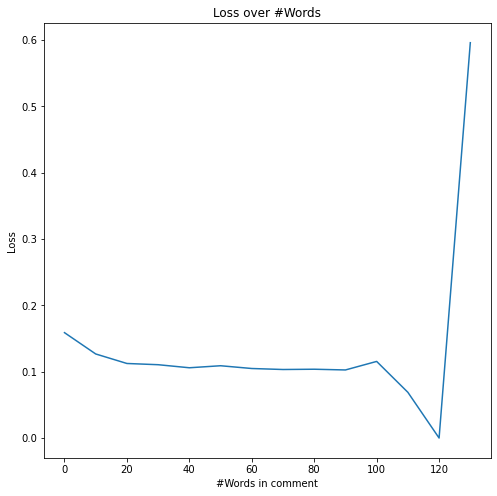

In [41]:
# Plot curve of loss over #words in comment
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(max_words_list, test_losses)
plt.title("Loss over #Words")
plt.xlabel("#Words in comment")
plt.ylabel("Loss")
plt.show()

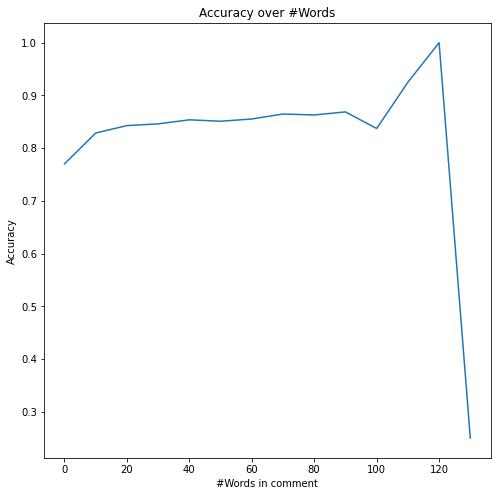

In [42]:
# Plot curve of accuracy over #words in comment
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(max_words_list, test_accuracies)
plt.title("Accuracy over #Words")
plt.xlabel("#Words in comment")
plt.ylabel("Accuracy")
plt.show()

### $Conclusion$

Overall, the performances are still affected by the number of positive feature values (words in a comment). But there were less fluctuations, this could be because the combination of problems acssociating with episode 1's models has now shifted slightly to just the problem about the number of positive feature values.

# IX. Thank you

Thank you for viewing my project. I hope it didn't bore you. See you in the next episode!